Para abrir o notebook no Google Colab, altere o domínio `github.com` para `githubtocolab.com`

<div class="alert alert-block alert-danger">
Para praticar programação, é importante que você erre, leia as mensagens de erro e tente corrigí-los.
    
Dessa forma, no Google Colab, é importante que você DESATIVE OS RECURSOS DE AUTOCOMPLETAR:

- Menu Ferramentas -> Configurações
- Na janela que é aberta:
  - Seção Editor -> Desativar "Mostrar sugestões de preenchimento de código com base no contexto"
  - Seção Assistência de IA -> Desabilitar itens

Na versão em inglês:

- Menu Tools -> Settings
- Na janela que é aberta:
  - Seção Editor -> Desativar "Show context-powered code completions"
  - Seção AI Assistance -> Desabilitar itens
</div>

# PSI5892 - Aula de Exercícios

# MLP genérica para solução do problemas das meias luas - Função custo da entropia cruzada

Neste exercício, vamos treinar uma rede MLP semelhante à do exercício anterior, mas usando a função custo da entropia cruzada.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Vamos gerar os dados de treinamento do problema das meias-luas. Note que, no caso da função custo da entropia cruzada, precisamos definir o sinal desejado no conjunto $\{0, 1\}$.

In [2]:
def meias_luas(NA, NB, r1, r2, r3):
    """
    dados = meias_luas(NA,NB,r1,r2,r3)
    NA: número de pontos da região A
    NB: número de pontos da região B
    r1, r2 e r3: dados das meias-luas
    """

    # total de dados de treinamento
    Nt = NA + NB

    # dados das meia luas
    rmin = r1 - r3 / 2
    rmax = r1 + r3 / 2

    # Pontos da Região A
    a = np.pi * np.random.rand(NA, 1)
    rxy = np.random.uniform(rmin, rmax, (NA, 1))
    x1A = rxy * np.cos(a)
    x2A = rxy * np.sin(a)
    dA = np.ones((NA, 1))
    pontosA = np.hstack((x1A, x2A, dA))

    # Pontos da Região B
    a = np.pi * np.random.rand(NB, 1)
    rxy = np.random.uniform(rmin, rmax, (NB, 1))
    x1B = rxy * np.cos(a) + r1
    x2B = -rxy * np.sin(a) - r2
    dB = np.zeros((NB, 1))
    pontosB = np.hstack((x1B, x2B, dB))

    # Concatenando e embaralhando os dados
    dados = np.vstack((pontosA, pontosB))
    np.random.shuffle(dados)

    # Figura para mostrar os dados de treino
    fig, ax1 = plt.subplots()
    ax1.plot(x1A, x2A, ".b")
    ax1.plot(x1B, x2B, ".r")
    plt.xlabel("x_1")
    plt.ylabel("x_2")
    plt.grid(axis="x", color="0.5")
    plt.grid(axis="y", color="0.5")

    return dados

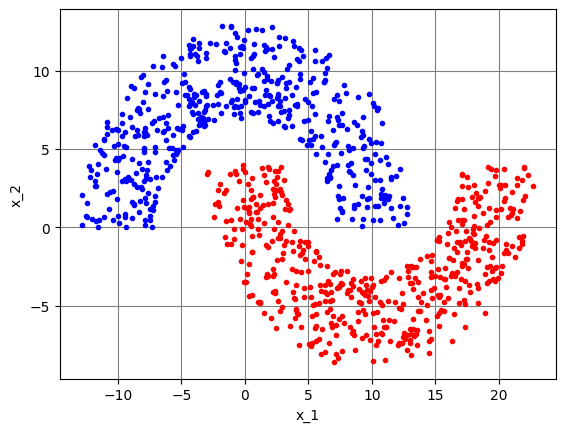

In [3]:
# número de pontos de treinamento da Região A
NA = 500

# número de pontos de treinamento da Região B
NB = 500

# número total de dados de treinamento
Nt = NA + NB

r1 = 10
r3 = 6
r2 = -4

dados_treino = meias_luas(NA, NB, r1, r2, r3)

In [4]:
# organizando os dados para entrada da MLP

# sinal de entrada
x = dados_treino[:, [0, 1]]

# sinal desejado
d = dados_treino[:, [2]]

# Exercício 1

Implemente uma função para treinamento de uma rede MLP genérica usando o algoritmo do gradiente estocástico, considerando a função custo da entropia cruzada, dada por

$$J_{\rm EC} = -\left[d_1(n){\rm ln}\left(y_1^{(L)}(n)\right) + \left(1 - d_1(n)\right){\rm ln}\left(1 - y_1^{(L)}(n)\right)\right].$$

Note que o caso com a entropia cruzada pressupõe que a rede possua apenas uma saída e, levando em conta que o sinal desejado tem elementos no conjunto $\{0, 1\}$, é necessário utilizar uma função de ativação sigmoidal.

Considere a seguinte assinatura para a função:

```python
def redeMLP_SGD_EC(x, d, Nn, eta, Nt, Nb, Ne, W0):
    """
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    eta: passo de adaptação
    Nt: número de dados de treinamento
    Nb: tamanho do mini-batch
    Ne: número de épocas
    W0: matriz de pesos iniciais (inclui o bias)
        utilize um tensor de dimensões np.max(Nn) x np.max(Nn) + 1 x L
        para armazenar os pesos, sendo L o número de camadas da rede
    Saídas:
    J_MSE: valor da função custo ao longo das épocas
    W: matriz de pesos (inclui o bias) da última época
       utilize um tensor de mesmas dimensões de W0
    """
```

Após implementação da função para treinamento, treine uma rede para solucionar o problemas das meias luas considerando os dados `x`e `d` criados anteriormente. Faça um gráfico da função custo ao longo das épocas de treinamento.

## Resolução

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def redeMLP_SGD_EC(x, d, Nn, eta, Nt, Nb, Ne, W0=None):
    """
    Treinamento de uma rede MLP genérica usando SGD e função custo da entropia cruzada.

    Entradas:
    ----------
    x : np.ndarray (Nt x Nn[0])
        Sinal de entrada
    d : np.ndarray (Nt x 1)
        Sinal desejado no conjunto {0,1}
    Nn : list
        Estrutura da rede. Ex: [2, 5, 1]
    eta : float
        Taxa de aprendizado
    Nt : int
        Número de amostras de treinamento
    Nb : int
        Tamanho do mini-batch
    Ne : int
        Número de épocas
    W0 : np.ndarray (max(Nn), max(Nn)+1, L) opcional
        Tensor com pesos iniciais (inclui bias)

    Saídas:
    -------
    J_EC : np.ndarray
        Valor da função custo (entropia cruzada) por época
    W : np.ndarray
        Tensor de pesos da última época (mesma forma de W0)
    """

    # Número de camadas (sem contar entrada)
    L = len(Nn) - 1
    Nmax = np.max(Nn)

    # Inicialização dos pesos
    if W0 is None:
        W = np.zeros((Nmax, Nmax + 1, L))
        for j in range(L):
            W[:Nn[j+1], :Nn[j]+1, j] = np.random.uniform(-0.5, 0.5, (Nn[j+1], Nn[j]+1))
    else:
        W = np.copy(W0)

    # Funções de ativação
    f_tanh = lambda x: np.tanh(x)
    f_deriv_tanh = lambda x: 1 - np.tanh(x)**2
    f_sig = lambda x: 1 / (1 + np.exp(-x))

    # Vetor para armazenar custo (entropia cruzada)
    J_EC = np.zeros(Ne)

    # Loop de treinamento
    for epoca in range(Ne):
        erro_epoca = 0.0

        # embaralhar dados
        idx = np.random.permutation(Nt)
        x = x[idx, :]
        d = d[idx, :]

        for i in range(0, Nt, Nb):
            x_batch = x[i:i+Nb, :]
            d_batch = d[i:i+Nb, :]

            # gradientes acumulados
            grad_W = np.zeros_like(W)

            for n in range(len(x_batch)):
                # ----- FORWARD -----
                y = [None] * (L + 1)
                v = [None] * (L + 1)
                y[0] = x_batch[n, :].reshape(-1, 1)

                for j in range(1, L + 1):
                    xj = np.vstack(([1], y[j-1]))  # inclui bias
                    v[j] = W[:Nn[j], :Nn[j-1]+1, j-1] @ xj
                    if j < L:
                        y[j] = f_tanh(v[j])
                    else:
                        y[j] = f_sig(v[j])

                # ----- ERRO E CUSTO -----
                d_n = d_batch[n, 0]
                yL = y[L][0, 0]
                erro_epoca += -(d_n*np.log(yL + 1e-12) + (1-d_n)*np.log(1-yL + 1e-12))

                # ----- BACKWARD -----
                delta = [None] * (L + 1)
                delta[L] = (y[L] - d_batch[n, :].reshape(-1, 1))  # saída sigmoide + EC simplificada

                for j in range(L-1, 0, -1):
                    Wj = W[:Nn[j+1], :Nn[j]+1, j]
                    W_no_bias = Wj[:, 1:]
                    delta[j] = f_deriv_tanh(v[j]) * (W_no_bias.T @ delta[j+1])

                # acumular gradientes
                for j in range(1, L + 1):
                    xj = np.vstack(([1], y[j-1]))
                    grad_W[:Nn[j], :Nn[j-1]+1, j-1] += eta * (delta[j] @ xj.T)

            # atualizar pesos (média no mini-batch)
            W -= grad_W / Nb

        # custo médio da época
        J_EC[epoca] = erro_epoca / Nt

    # Plot do custo
    plt.figure(figsize=(7,5))
    plt.plot(J_EC, 'r-', linewidth=2)
    plt.title('Evolução da Função Custo (Entropia Cruzada)')
    plt.xlabel('Época')
    plt.ylabel('J_EC')
    plt.grid(True)
    plt.show()

    return J_EC, W


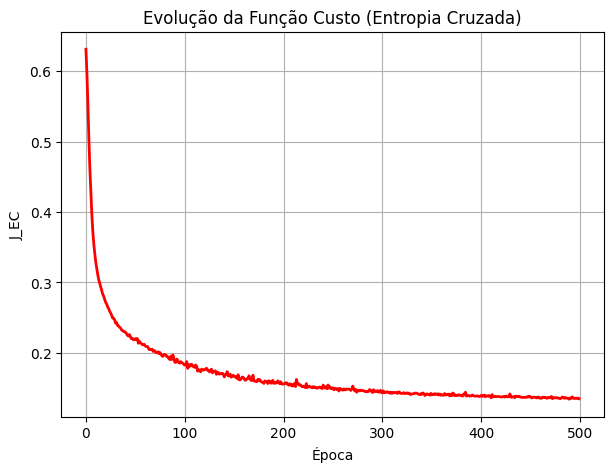

In [10]:
# Estrutura da rede
Nn = [2, 3, 2, 1]
eta = 0.01
Nb = 20
Ne = 500

# Inicialização dos pesos
Nmax = np.max(Nn)
L = len(Nn) - 1
W0 = np.random.uniform(-0.5, 0.5, (Nmax, Nmax + 1, L))

# Treinamento
J_EC, W_final = redeMLP_SGD_EC(x, d, Nn, eta, Nt, Nb, Ne, W0)

# Exercício 2

Utilizando os seguintes dados de teste:

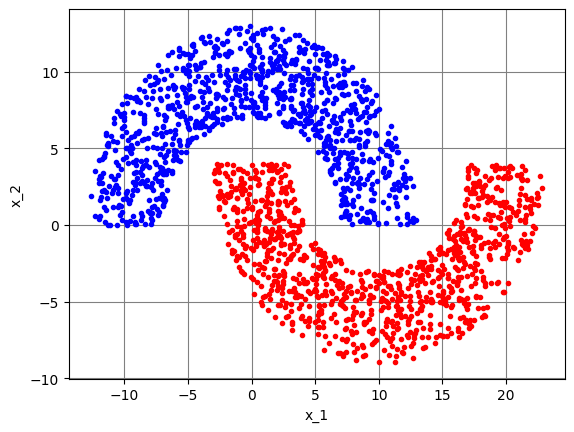

In [13]:
# Dados de teste
NAt = 1000
NBt = 1000
Nteste = NAt + NBt

dados_teste = meias_luas(NAt, NBt, r1, r2, r3)

# entrada
xteste = dados_teste[:, 0:2]  # sinal de entrada

# sinal desejado
dteste = dados_teste[:, 2].reshape(-1, 1)

Implemente uma função para teste da rede MLP treinada anteriormente, com a seguinte assinatura:

``` python
def redeMLP_SGD_EC_teste(x, d, W, Nn, Nteste):
    """
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    W: matriz de pesos (inclui o bias) da última época (mesmo formato do treinamento)
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    Nteste: número de dados de teste
    Saídas:
    J_MSE: valor da função custo no teste
    y: saída da rede MLP
    """
```

Em seguida, faça o teste da rede com os dados de teste, apresente a taxa de erro e a curva de separação das duas regiões obtidas com a rede treinada.

## Resolução

In [14]:
import numpy as np

def redeMLP_SGD_EC_teste(x, d, W, Nn, Nteste):
    """
    Teste de uma rede MLP treinada com Entropia Cruzada.

    Entradas:
    ----------
    x : np.ndarray (Nteste x Nn[0])
        Sinal de entrada
    d : np.ndarray (Nteste x 1)
        Sinal desejado no conjunto {0, 1}
    W : np.ndarray
        Tensor de pesos (Nmax, Nmax+1, L)
    Nn : list
        Estrutura da rede. Ex: [2, 6, 1]
    Nteste : int
        Número de amostras de teste

    Saídas:
    -------
    J_MSE : float
        Erro quadrático médio no teste
    y : np.ndarray (Nteste x 1)
        Saída da rede MLP
    """

    # Funções de ativação
    def tanh(x): return np.tanh(x)
    def sigmoid(x): return 1 / (1 + np.exp(-x))

    L = len(Nn) - 1
    Nmax = np.max(Nn)
    y_saida = np.zeros((Nteste, 1))

    # ---- Forward pass para todos os dados de teste ----
    for n in range(Nteste):
        y = [None] * (L + 1)
        v = [None] * (L + 1)
        y[0] = x[n, :].reshape(-1, 1)

        for j in range(1, L + 1):
            xj = np.vstack(([1.0], y[j-1]))                     # adiciona bias
            Wj = W[:Nn[j], :Nn[j-1]+1, j-1]
            v[j] = Wj @ xj
            if j < L:
                y[j] = tanh(v[j])
            else:
                y[j] = sigmoid(v[j])

        y_saida[n, 0] = y[L][0, 0]

    # ---- Cálculo do erro quadrático médio ----
    e = d - y_saida
    J_MSE = np.mean(e**2)

    return J_MSE, y_saida


In [15]:
# ---- Teste da rede MLP ----
J_teste, y_teste = redeMLP_SGD_EC_teste(xteste, dteste, W_final, Nn, Nteste)

# Classificação binária (limiar = 0.5)
pred = (y_teste >= 0.5).astype(int)

# Taxa de acerto e erro
acerto = np.mean(pred == dteste)
erro = 1 - acerto

print(f"Erro quadrático médio no teste: {J_teste:.6f}")
print(f"Taxa de acerto: {acerto*100:.2f}%")
print(f"Taxa de erro:  {erro*100:.2f}%")


Erro quadrático médio no teste: 0.047735
Taxa de acerto: 93.00%
Taxa de erro:  7.00%


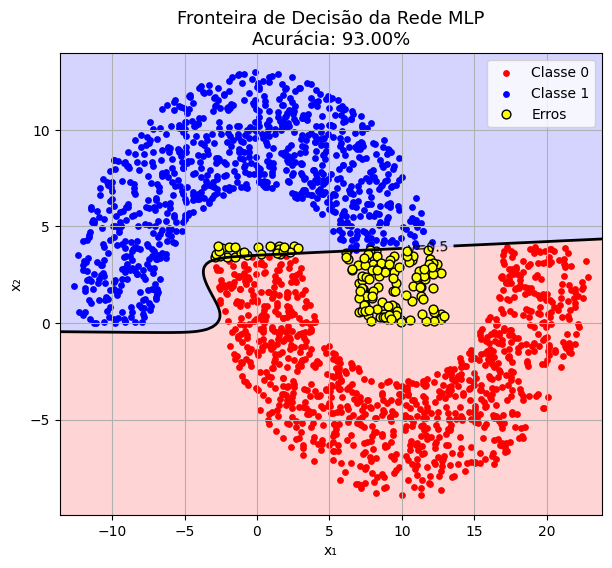

In [16]:
# ---- Curva de separação ----
# Geração de uma grade de pontos
x1_min, x1_max = xteste[:,0].min()-1, xteste[:,0].max()+1
x2_min, x2_max = xteste[:,1].min()-1, xteste[:,1].max()+1
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 200),
                       np.linspace(x2_min, x2_max, 200))
X_grid = np.c_[xx1.ravel(), xx2.ravel()]

# Saída da rede na grade
_, y_grid = redeMLP_SGD_EC_teste(X_grid, np.zeros((len(X_grid),1)), W_final, Nn, len(X_grid))
Z = y_grid.reshape(xx1.shape)

# ---- Plotando ----
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))

# Regiões coloridas
plt.contourf(xx1, xx2, Z, levels=[0, 0.5, 1], colors=['#FFAAAA', '#AAAAFF'], alpha=0.5)

# Fronteira de decisão
cs = plt.contour(xx1, xx2, Z, levels=[0.5], colors='k', linewidths=2)
plt.clabel(cs, fmt='y=0.5', inline=True)

# Pontos do conjunto de teste
plt.scatter(xteste[dteste[:,0]==0,0], xteste[dteste[:,0]==0,1], c='red', label='Classe 0', s=15)
plt.scatter(xteste[dteste[:,0]==1,0], xteste[dteste[:,0]==1,1], c='blue', label='Classe 1', s=15)

# Pontos incorretos (classificação errada)
plt.scatter(xteste[pred[:,0]!=dteste[:,0],0],
            xteste[pred[:,0]!=dteste[:,0],1],
            c='yellow', s=40, edgecolors='k', label='Erros')

plt.title(f"Fronteira de Decisão da Rede MLP\nAcurácia: {acerto*100:.2f}%", fontsize=13)
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.legend()
plt.grid(True)
plt.show()
